## Import

In [ ]:
import os, gc, warnings, random, math
import datetime
from datetime import timedelta
from joblib import Parallel, delayed
import multiprocessing
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import copy
import pickle
import json

from time import sleep
from tqdm.contrib import tzip

warnings.filterwarnings('ignore')

import tensorflow as tf

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from xgboost import XGBClassifier, XGBRegressor

import torch
from torch.optim import Rprop

from random import seed

from tensorflow.keras import backend as K
from tensorflow.keras import initializers

from math import floor
from itertools import chain

import pandas as pd
import numpy as np
import operator
import sklearn

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler #менее подвержан выбросам
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
!pip install imblearn
from imblearn.over_sampling import SMOTE
import itertools
from collections import Counter
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,\
roc_auc_score,roc_curve,matthews_corrcoef,recall_score,precision_score,classification_report,f1_score,cohen_kappa_score, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Настройки визуализации
%matplotlib inline
plt.style.use('ggplot')
sns.set(style='whitegrid')
sns.set_context('talk')
%config InlineBackend.figure_format = 'svg' #Отображение графиков в формате svg

## Определение функций

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix',cmap=plt.cm.Blues, norm=False, name = "default"):
    """
    Эта функция строит матрицу ошибок
    """
    fig, ax = plt.subplots(figsize=(12,8))
    
    if norm == True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round_(cm, decimals=3)
    
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.grid(False)
    thetime = datetime.datetime.now().strftime("%d_%m_%Y_%H_%M_%S")
    plt.savefig(f'../svg/confusion_matrix_{name}_{thetime}.svg')
    plt.savefig(f'../png/confusion_matrix_{name}_{thetime}.png', dpi=300)
    plt.show()



In [ ]:
###################################################################################
def max_min_scaler_norm_for_columns (df):
  """Нормализует столбцы dataframe"""
  columns = []
  columns = df.columns
  target_columns = []
  for i in columns:
    if (df[i].max() > 1)or(df[i].min() < 0):
      target_columns.append(i)
  for i in target_columns:
    df[i] = (df[i] - df[i].min())/(df[i].max()-df[i].min())

def max_min_scaler_norm_for_the_columns (df, columns):
  """Нормализует столбцы dataframe"""
  for i in columns:
    df[i] = (df[i] - df[i].min())/(df[i].max()-df[i].min())

def max_min_scaler_denorm_for_the_column (array_to_denorm, source_df, column):
  """Денормализует заданый столбец"""
  denormed_array = (array_to_denorm + source_df[column].min())*(source_df[column].max()-source_df[column].min())  
  return denormed_array
###################################################################################

In [ ]:
def dataframe_to_data_and_target_lists (df, long_of_list):
  """Построение data и target"""
  array_df = df.to_numpy()
  data = np.zeros((len(array_df)-long_of_list,long_of_list,len(df.columns)), dtype = float)
  target = np.zeros((len(array_df)-long_of_list, 1), dtype = float)
  for i in range(0, (len(array_df)-long_of_list)):
    for j in range(0, long_of_list):
      data[i][j] = array_df[i+j]
  for k in range(0, (len(array_df)-long_of_list)):
    target[k] = array_df[k+long_of_list][0]                       #Время должно быть в первом столбце
  return np.array(data, dtype = float), np.array(target, dtype = float)

In [ ]:
def accuracy_score(y_true, y_predict):
  TP, FP, FN, TN = conf_matrix_bin(y_true, y_predict)
  result = (TP+TN)/(TP+TN+FP+FN)
  return result

def conf_matrix_bin (y_true, y_predict):
  TP = sum(np.array([(1 if (y_true[i]==1 and y_predict[i]==1) else 0) for i in range(len(y_true))]))
  FP = sum(np.array([(1 if (y_true[i]==0 and y_predict[i]==1) else 0) for i in range(len(y_true))]))
  FN = sum(np.array([(1 if (y_true[i]==1 and y_predict[i]==0) else 0) for i in range(len(y_true))]))
  TN = sum(np.array([(1 if (y_true[i]==0 and y_predict[i]==0) else 0) for i in range(len(y_true))]))
  return TP, FP, FN, TN

## Основные параметры модуля

In [ ]:
DATA_PATH = '../data/'
PNG_PATH = '../png/'
PREPROCESSED_DATA_PATH = '../preprocessed data/'
SGB_MODELS_PATH = '../xgb_models/'
SGB_RESULTS_PATH = '../xgb_results/'
SGB_HISTORY_PATH = '../xgb_histories/'

## Получение данных

In [ ]:
df_svista = pd.read_csv(f'{PREPROCESSED_DATA_PATH}prep_data.csv')
df_clusters = pd.read_csv(f'{PREPROCESSED_DATA_PATH}data_clusters.csv')

In [ ]:
df_svista

In [ ]:
df_clusters

## Модели для кластеров

### Создание словаря кластеров

In [ ]:
df_svista_cl = df_svista.merge(df_clusters, on=["CARDID_NUM"])

In [ ]:
df_svista_cl['labels_PCA'].unique()

array([3, 0, 1, 2], dtype=int64)

In [ ]:
df_cl_cards_dict = {}
for i in df_svista_cl['labels_PCA'].unique():
  df_cl_cards_dict[i] = df_svista_cl[df_svista_cl['labels_PCA']==i].copy(deep=True)
  df_cl_cards_dict[i] = df_cl_cards_dict[i].sort_values(['CARDID_NUM','DATE_TIME_SEC'], ascending=[True,True])
  df_cl_cards_dict[i].drop(columns=['labels_PCA'], inplace=True)
  df_cl_cards_dict[i].reset_index(drop=True, inplace=True)

In [ ]:
df_cl_cards_dict[3]

### Нормализация

In [ ]:
df_cl_cards_dict_norm = {}
scaler = RobustScaler()
for i in df_cl_cards_dict.keys():
  df_cl_cards_dict_norm[i] = df_cl_cards_dict[i].copy(deep=True)
  df_cl_cards_dict_norm[i][['AMOUNT','AMOUNT_INST']] = scaler.fit_transform(df_cl_cards_dict_norm[i][['AMOUNT','AMOUNT_INST']])
  columns_to_norm = ['DATE_TIME_SEC','TIME_DIFF']
  max_min_scaler_norm_for_the_columns(df_cl_cards_dict_norm[i], columns_to_norm)

In [ ]:
### Передвигаем столбцы в начало
for i in df_cl_cards_dict_norm.keys():
  DATE_TIME_SEC_array = df_cl_cards_dict_norm[i]['DATE_TIME_SEC']
  df_cl_cards_dict_norm[i].drop(['DATE_TIME_SEC'], axis=1, inplace=True)
  df_cl_cards_dict_norm[i].insert(0, 'DATE_TIME_SEC', DATE_TIME_SEC_array)

In [ ]:
df_cl_cards_dict_norm[3]

### Посроение data & target

In [ ]:
df_cl_dict_dict_norm = {}
for i in df_cl_cards_dict_norm.keys():
  df_temp_cards = {}
  for j in df_cl_cards_dict_norm[i]['CARDID_NUM'].unique():
    df_temp_cards[j] = df_cl_cards_dict_norm[i][df_cl_cards_dict_norm[i]['CARDID_NUM']==j]
    df_temp_cards[j].drop(columns=['CARDID_NUM'],inplace=True)
    df_temp_cards[j] = df_temp_cards[j].sort_values(['DATE_TIME_SEC'])
    df_temp_cards[j].reset_index(drop=True, inplace=True)
  df_cl_dict_dict_norm[i] = df_temp_cards

In [ ]:
for i in df_cl_dict_dict_norm.keys():
  print(i, df_cl_dict_dict_norm[i].keys(), sep='  ')

In [ ]:
data_clusters = {}
target_clusters = {}
x_train_clusters = {}
x_test_clusters = {}
y_train_clusters = {}
y_test_clusters = {}
### Количество транзакций в одном ряду (предсказываем время long_of_list+1 исходя из long_of_list прошлых)
long_of_list_clusters = 10
for i in df_cl_dict_dict_norm.keys():
  data_temp = {}
  target_temp = {}
  x_train_temp = {}
  x_test_temp = {}
  y_train_temp = {}
  y_test_temp = {}
  for j in df_cl_dict_dict_norm[i].keys():
    data_temp[j], target_temp[j] = dataframe_to_data_and_target_lists(df_cl_dict_dict_norm[i][j], long_of_list_clusters)
    x_train_temp[j], x_test_temp[j], y_train_temp[j], y_test_temp[j] = train_test_split(data_temp[j],target_temp[j],test_size=0.2, shuffle = False, random_state=4)
  data_clusters[i] = data_temp
  target_clusters[i] = target_temp
  x_train_clusters[i] = x_train_temp
  x_test_clusters[i] = x_test_temp
  y_train_clusters[i] = y_train_temp
  y_test_clusters[i] = y_test_temp


In [ ]:
print(x_train_clusters[3][0].shape)
print(x_test_clusters[3][0].shape)
print(y_train_clusters[3][0].shape)
print(y_test_clusters[3][0].shape)
print(data_clusters[3][0].shape)
print(target_clusters[3][0].shape)

In [ ]:
data_clusters_full = {}
target_clusters_full = {}
x_train_clusters_full = {}
x_test_clusters_full = {}
y_train_clusters_full = {}
y_test_clusters_full = {}
for i in tqdm(df_cl_dict_dict_norm.keys()):
  data_clusters_full[i] = np.zeros((1,data_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[1],data_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[2]))
  target_clusters_full[i] = np.zeros((1,target_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[1]))
  x_train_clusters_full[i] = np.zeros((1,x_train_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[1],x_train_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[2]))
  x_test_clusters_full[i] = np.zeros((1,x_test_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[1],x_test_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[2]))
  y_train_clusters_full[i] = np.zeros((1,y_train_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[1]))
  y_test_clusters_full[i] = np.zeros((1,y_test_clusters[i][list(df_cl_dict_dict_norm[i].keys())[0]].shape[1]))
  for j in df_cl_dict_dict_norm[i].keys():
    data_clusters_full[i] = np.vstack((data_clusters_full[i], data_clusters[i][j]))
    target_clusters_full[i] = np.vstack((target_clusters_full[i], target_clusters[i][j]))
    x_train_clusters_full[i] = np.vstack((x_train_clusters_full[i], x_train_clusters[i][j]))
    x_test_clusters_full[i] = np.vstack((x_test_clusters_full[i], x_test_clusters[i][j]))
    y_train_clusters_full[i] = np.vstack((y_train_clusters_full[i], y_train_clusters[i][j]))
    y_test_clusters_full[i] = np.vstack((y_test_clusters_full[i], y_test_clusters[i][j]))

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.65it/s]


In [ ]:
#Удаляем запись, которая использовалась для инициализации массивов
for i in df_cl_dict_dict_norm.keys():
  data_clusters_full[i] = data_clusters_full[i][1:]
  target_clusters_full[i] = target_clusters_full[i][1:]
  x_train_clusters_full[i] = x_train_clusters_full[i][1:]
  x_test_clusters_full[i] = x_test_clusters_full[i][1:]
  y_train_clusters_full[i] = y_train_clusters_full[i][1:]
  y_test_clusters_full[i] = y_test_clusters_full[i][1:]

### Получение бинарной целевой переменной

#### Денормализация

In [ ]:
data_clusters_full_dn = copy.deepcopy(data_clusters_full)

target_clusters_full_dn = copy.deepcopy(target_clusters_full)

x_train_clusters_full_dn = copy.deepcopy(x_train_clusters_full)
x_test_clusters_full_dn = copy.deepcopy(x_test_clusters_full)
y_train_clusters_full_dn = copy.deepcopy(y_train_clusters_full)
y_test_clusters_full_dn = copy.deepcopy(y_test_clusters_full)


In [ ]:
data_clusters_full[0][0,:,0]

In [ ]:
### Денормализация
for i in df_cl_dict_dict_norm.keys():
  
  for j in range(data_clusters_full_dn[i].shape[0]):
    data_clusters_full_dn[i][j,:,0] = max_min_scaler_denorm_for_the_column(data_clusters_full_dn[i][j,:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')
  
  target_clusters_full_dn[i][:,0] = max_min_scaler_denorm_for_the_column(target_clusters_full_dn[i][:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')

  for j in range(x_train_clusters_full_dn[i].shape[0]):
    x_train_clusters_full_dn[i][j,:,0] = max_min_scaler_denorm_for_the_column(x_train_clusters_full_dn[i][j,:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')
  
  for j in range(x_test_clusters_full_dn[i].shape[0]):
    x_test_clusters_full_dn[i][j,:,0] = max_min_scaler_denorm_for_the_column(x_test_clusters_full_dn[i][j,:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')
  
  y_train_clusters_full_dn[i][:,0] = max_min_scaler_denorm_for_the_column(y_train_clusters_full_dn[i][:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')

  y_test_clusters_full_dn[i][:,0] = max_min_scaler_denorm_for_the_column(y_test_clusters_full_dn[i][:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')



In [ ]:
print(x_train_clusters_full_dn[1].shape)
print(x_test_clusters_full_dn[1].shape)
print(y_train_clusters_full_dn[1].shape)
print(y_test_clusters_full_dn[1].shape)
print(data_clusters_full_dn[1].shape)
print(target_clusters_full_dn[1].shape)

#### Получение бинарного признака

In [ ]:
transaction_before_x_test_cl = {}
transaction_before_x_train_cl = {}
actual_y_test_cl = {}
actual_y_train_cl = {}
actual_class_test_cl = {}
actual_class_train_cl = {}

In [ ]:
#Получаем время транзакций (последней в ряду, действительное время предсказываемой транзакции и предсказанное время)
for i in df_cl_dict_dict_norm.keys():
  transaction_before_x_test_cl[i] = x_test_clusters_full_dn[i][:,(x_test_clusters_full_dn[i].shape[1]-1),0] # последняя транзакция в ряду
  transaction_before_x_train_cl[i] = x_train_clusters_full_dn[i][:,(x_train_clusters_full_dn[i].shape[1]-1),0] # последняя транзакция в ряду
  actual_y_test_cl[i] = y_test_clusters_full_dn[i][:,0] #реальное время след транзакции по картам
  actual_y_train_cl[i] = y_train_clusters_full_dn[i][:,0] #реальное время след транзакции по картам
  actual_class_test_cl[i] = np.empty((actual_y_test_cl[i].shape[0]), dtype=float)
  actual_class_train_cl[i] = np.empty((actual_y_train_cl[i].shape[0]), dtype=float)

In [ ]:
print(actual_y_test_cl[0].shape,transaction_before_x_test_cl[0].shape, sep=' ')
print(actual_y_train_cl[0].shape,transaction_before_x_train_cl[0].shape, sep=' ')

In [ ]:
#Строим массивы с бинарной классификацией транзакций которые произошли в следующие window_min минут после последней транзакции в ряду
window_min = 30
for j in tqdm(df_cl_dict_dict_norm.keys()):
  for i in range(0, actual_class_test_cl[j].shape[0]):
    if (actual_y_test_cl[j][i]<=((window_min*60)+transaction_before_x_test_cl[j][i])):
      actual_class_test_cl[j][i] = 1
    else:
      actual_class_test_cl[j][i] = 0
  for i in range(0, actual_class_train_cl[j].shape[0]):
    if (actual_y_train_cl[j][i]<=((window_min*60)+transaction_before_x_train_cl[j][i])):
      actual_class_train_cl[j][i] = 1
    else:
      actual_class_train_cl[j][i] = 0
  actual_class_test_cl[j] = actual_class_test_cl[j].astype('int32')
  actual_class_test_cl[j] = actual_class_test_cl[j].astype('int32')

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 70.18it/s]


In [ ]:
actual_y_test_cl[2].shape

(67,)

In [ ]:
actual_class_test_cl[2].shape

(67,)

In [ ]:
actual_y_train_cl[0].shape

(2056,)

In [ ]:
actual_class_train_cl[0].shape

(2056,)

### Получение формы необходимой для xgboost

In [ ]:
x_test_clusters_full_xgb = {}
x_train_clusters_full_xgb = {}
for i in df_cl_dict_dict_norm.keys():
  x_test_clusters_full_xgb[i] = x_test_clusters_full[i].reshape(x_test_clusters_full[i].shape[0],-1)
  x_train_clusters_full_xgb[i] = x_train_clusters_full[i].reshape(x_train_clusters_full[i].shape[0],-1)

In [ ]:
actual_class_train_cl[0].shape

(2056,)

In [ ]:
x_train_clusters_full_xgb[0].shape

(2056, 170)

In [ ]:
x_test_clusters_full_xgb[0].shape

(568, 170)

In [ ]:
x_train_clusters_full_xgb[0].shape

(2056, 170)

### Обучение моделей классификации

In [ ]:
models_cl_xgb = []
for i in tqdm(df_cl_dict_dict_norm.keys()):
  seed(42)
  model = XGBClassifier()
  models_cl_xgb.append(model)

100%|██████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 3909.86it/s]


In [ ]:
for model,i in tzip(models_cl_xgb, df_cl_dict_dict_norm.keys()):
    model.fit(x_train_clusters_full_xgb[i], actual_class_train_cl[i])

  0%|          | 0/4 [00:00<?, ?it/s]

[21:03:04] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:06] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:10] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:03:12] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

In [ ]:
pred_class_cl_xgb = {}
for model, i in tzip(models_cl_xgb, df_cl_dict_dict_norm.keys()):
  pred_class_cl_xgb[i] = model.predict(x_test_clusters_full_xgb[i]) 

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
accuracy_clusters_class = {}
for i in df_cl_dict_dict_norm.keys():
  accuracy_clusters_class[i] = classification_report(actual_class_test_cl[i], pred_class_cl_xgb[i], output_dict=True)['accuracy']
  print(f'CLUSTER {i}')
  print(classification_report(actual_class_test_cl[i], pred_class_cl_xgb[i]))
  print('_'*80)

CLUSTER 3
              precision    recall  f1-score   support

           0       0.75      0.47      0.58       113
           1       0.81      0.93      0.87       269

    accuracy                           0.80       382
   macro avg       0.78      0.70      0.72       382
weighted avg       0.79      0.80      0.78       382

________________________________________________________________________________
CLUSTER 0
              precision    recall  f1-score   support

           0       0.79      0.76      0.77       343
           1       0.65      0.69      0.67       225

    accuracy                           0.73       568
   macro avg       0.72      0.72      0.72       568
weighted avg       0.73      0.73      0.73       568

________________________________________________________________________________
CLUSTER 1
              precision    recall  f1-score   support

           0       0.78      0.83      0.81       237
           1       0.63      0.56      0.59  

#### Важность признаков

In [ ]:
columns_fi = []
for i in range(10):
  columns_fi = columns_fi + list(df_cl_dict_dict_norm[0][9].columns)

In [ ]:
fi = {}
for model, i in zip(models_cl_xgb, df_cl_dict_dict_norm.keys()):
  fi[i] = pd.DataFrame({'w':model.feature_importances_,'name':columns_fi})

In [ ]:
for i in df_cl_dict_dict_norm.keys():
  print('_'*70)
  print(f'       Cluster {i}')
  print(fi[i].sort_values('w',ascending=False).head(10))

______________________________________________________________________
       Cluster 3
            w           name
153  0.674135  DATE_TIME_SEC
136  0.208147  DATE_TIME_SEC
102  0.050455  DATE_TIME_SEC
51   0.027728  DATE_TIME_SEC
85   0.018696  DATE_TIME_SEC
68   0.004098  DATE_TIME_SEC
1    0.004052         AMOUNT
86   0.001562         AMOUNT
34   0.001520  DATE_TIME_SEC
17   0.000934  DATE_TIME_SEC
______________________________________________________________________
       Cluster 0
            w                    name
153  0.885383           DATE_TIME_SEC
119  0.027352           DATE_TIME_SEC
44   0.006981  MERCH_POSTAL_CODE_freq
123  0.004093                MCC_freq
136  0.004051           DATE_TIME_SEC
89   0.003820                MCC_freq
145  0.003694         MERCH_CITY_freq
102  0.003557           DATE_TIME_SEC
140  0.002693                MCC_freq
27   0.002432  MERCH_POSTAL_CODE_freq
______________________________________________________________________
       Cluster 1

In [ ]:
for i in df_cl_dict_dict_norm.keys():
  print('_'*70)
  print(f'       Cluster {i}')
  print(fi[i].sort_values('w',ascending=True).head(10))

______________________________________________________________________
       Cluster 3
       w                       name
84   0.0              PIN_PRES_freq
101  0.0              PIN_PRES_freq
100  0.0         PDC_CARD_PRES_freq
99   0.0  PDC_CARD_CAPTURE_CAP_freq
98   0.0            TRANS_TYPE_freq
97   0.0             CVV2_PRES_freq
96   0.0              MERCH_ID_freq
94   0.0            MERCH_CITY_freq
92   0.0   PDC_CARDHOLDER_PRES_freq
89   0.0                   MCC_freq
______________________________________________________________________
       Cluster 0
      w                       name
84  0.0              PIN_PRES_freq
48  0.0  PDC_CARD_CAPTURE_CAP_freq
49  0.0         PDC_CARD_PRES_freq
50  0.0              PIN_PRES_freq
58  0.0   PDC_CARDHOLDER_PRES_freq
65  0.0  PDC_CARD_CAPTURE_CAP_freq
67  0.0              PIN_PRES_freq
75  0.0   PDC_CARDHOLDER_PRES_freq
82  0.0  PDC_CARD_CAPTURE_CAP_freq
83  0.0         PDC_CARD_PRES_freq
___________________________________________

### Обучение моделей регрессии

In [ ]:
models_cl_xgb = []
for i in tqdm(df_cl_dict_dict_norm.keys()):
  seed(42)
  model = XGBRegressor()
  models_cl_xgb.append(model)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<?, ?it/s]


In [ ]:
y_test_clusters_full[0].shape

In [ ]:
x_train_clusters_full_xgb[0].shape

In [ ]:
for model,i in tzip(models_cl_xgb, df_cl_dict_dict_norm.keys()):
    model.fit(X=x_train_clusters_full_xgb[i],y=y_train_clusters_full[i])

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
pred_cl_xgb = {}
for model, i in tzip(models_cl_xgb, df_cl_dict_dict_norm.keys()):
  pred_cl_xgb[i] = model.predict(x_test_clusters_full_xgb[i]) 

  0%|          | 0/4 [00:00<?, ?it/s]

In [ ]:
pred_cl_xgb[0].shape

(568,)

### Визуализация

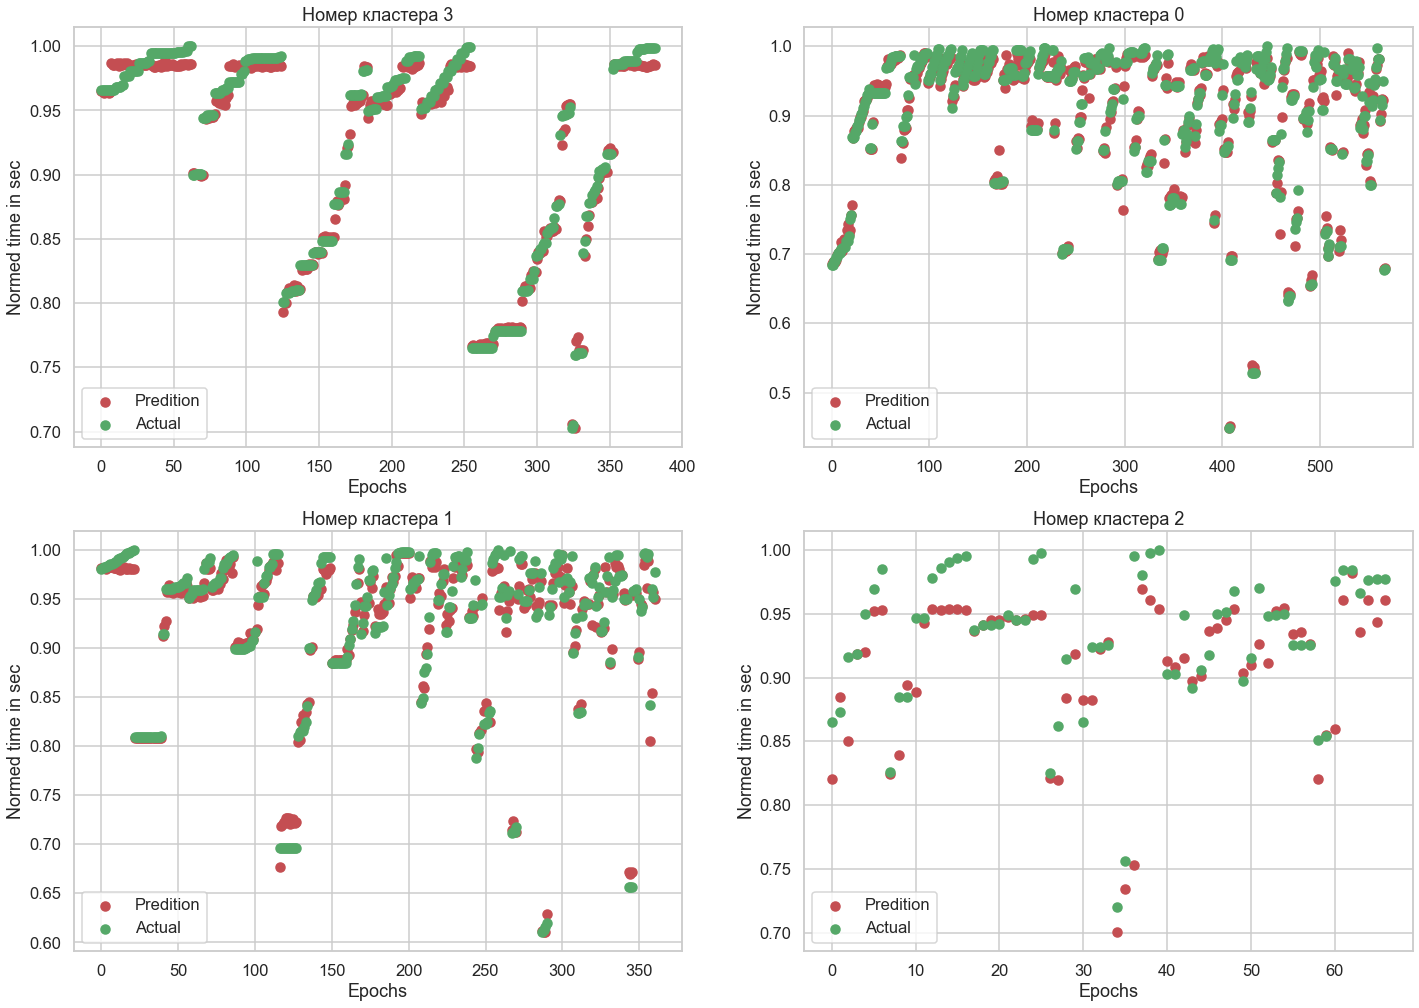

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.rcParams["figure.figsize"] = (24,(8.5*math.ceil(len(df_cl_dict_dict_norm.keys())/2))) #Размер поля

j=1
for i in df_cl_dict_dict_norm.keys():
  plt.subplot(math.ceil(len(df_cl_dict_dict_norm.keys())/2), 2, j)
  plt.scatter(range(y_test_clusters_full[i].shape[0]),np.array(pred_cl_xgb[i],dtype=float),c='r', label = 'Predition')
  plt.scatter(range(y_test_clusters_full[i].shape[0]),np.array(y_test_clusters_full[i],dtype=float),c='g', label = 'Actual')
  plt.title(f'Номер кластера {i}') 
  plt.xlabel('Epochs')
  plt.ylabel('Normed time in sec')
  plt.legend()
  plt.grid(True)
  j+=1

if not os.path.isfile(f'{PNG_PATH}/xgb_prediction_actual_clusters.png'):
  plt.savefig(f'{PNG_PATH}/xgb_prediction_actual_clusters', dpi=100)
plt.show()

### Получение accuracy

#### Денормализация

In [ ]:
data_clusters_full_dn = copy.deepcopy(data_clusters_full)

target_clusters_full_dn = copy.deepcopy(target_clusters_full)

x_train_clusters_full_dn = copy.deepcopy(x_train_clusters_full)
x_test_clusters_full_dn = copy.deepcopy(x_test_clusters_full)
y_train_clusters_full_dn = copy.deepcopy(y_train_clusters_full)
y_test_clusters_full_dn = copy.deepcopy(y_test_clusters_full)
model_results_save_cl_dn = copy.deepcopy(pred_cl_xgb)

In [ ]:
data_clusters_full[0][0,:,0]

In [ ]:
### Денормализация
for i in tqdm(df_cl_dict_dict_norm.keys()):
  
  for j in range(data_clusters_full_dn[i].shape[0]):
    data_clusters_full_dn[i][j,:,0] = max_min_scaler_denorm_for_the_column(data_clusters_full_dn[i][j,:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')
  
  target_clusters_full_dn[i][:,0] = max_min_scaler_denorm_for_the_column(target_clusters_full_dn[i][:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')

  for j in range(x_train_clusters_full_dn[i].shape[0]):
    x_train_clusters_full_dn[i][j,:,0] = max_min_scaler_denorm_for_the_column(x_train_clusters_full_dn[i][j,:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')
  
  for j in range(x_test_clusters_full_dn[i].shape[0]):
    x_test_clusters_full_dn[i][j,:,0] = max_min_scaler_denorm_for_the_column(x_test_clusters_full_dn[i][j,:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')
  
  y_train_clusters_full_dn[i][:,0] = max_min_scaler_denorm_for_the_column(y_train_clusters_full_dn[i][:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')

  y_test_clusters_full_dn[i][:,0] = max_min_scaler_denorm_for_the_column(y_test_clusters_full_dn[i][:,0], df_cl_cards_dict[i], 'DATE_TIME_SEC')

  model_results_save_cl_dn[i] = max_min_scaler_denorm_for_the_column(model_results_save_cl_dn[i], df_cl_cards_dict[i], 'DATE_TIME_SEC')


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:02<00:00,  1.40it/s]


In [ ]:
print(x_train_clusters_full_dn[1].shape)
print(x_test_clusters_full_dn[1].shape)
print(y_train_clusters_full_dn[1].shape)
print(y_test_clusters_full_dn[1].shape)
print(data_clusters_full_dn[1].shape)
print(target_clusters_full_dn[1].shape)
print(model_results_save_cl_dn[1].shape)

(1321, 10, 17)
(361, 10, 17)
(1321, 1)
(361, 1)
(1682, 10, 17)
(1682, 1)
(361,)


In [ ]:
for i in df_cl_dict_dict_norm.keys():
  print(i, y_test_clusters_full_dn[i].shape, model_results_save_cl_dn[i].shape, sep=' ')

3 (382, 1) (382,)
0 (568, 1) (568,)
1 (361, 1) (361,)
2 (67, 1) (67,)


#### Получение бинарного признака и расчет accuracy для отдельных кластеров

In [ ]:
transaction_before_x_test_cl = {}
actual_y_test_cl = {}
prediction_cl = {}
actual_class_cl = {}
result_class_cl = {}

In [ ]:
#Получаем время транзакций (последней в ряду, действительное время предсказываемой транзакции и предсказанное время)
for i in df_cl_dict_dict_norm.keys():
  transaction_before_x_test_cl[i] = x_test_clusters_full_dn[i][:,(x_test_clusters_full_dn[i].shape[1]-1),0] # последняя транзакция в ряду
  actual_y_test_cl[i] = y_test_clusters_full_dn[i][:,0] #реальное время след транзакции по картам
  prediction_cl[i] = model_results_save_cl_dn[i] #предсказания по картам
  actual_class_cl[i] = np.empty((actual_y_test_cl[i].shape[0]), dtype=float)
  result_class_cl[i] = np.empty((actual_y_test_cl[i].shape[0]), dtype=float)

In [ ]:
print(actual_y_test_cl[0].shape,transaction_before_x_test_cl[0].shape,prediction_cl[0].shape, sep=' ')

(568,) (568,) (568,)


In [ ]:
#Строим массивы с бинарной классификацией транзакций которые произошли в следующие window_min минут после последней транзакции в ряду
window_min = 30
for j in tqdm(df_cl_dict_dict_norm.keys()):
  for i in range(0, prediction_cl[j].shape[0]):
    if (actual_y_test_cl[j][i]<=((window_min*60)+transaction_before_x_test_cl[j][i])):
      actual_class_cl[j][i] = 1
    else:
      actual_class_cl[j][i] = 0
    if (prediction_cl[j][i]<=((window_min*60)+transaction_before_x_test_cl[j][i])):
      result_class_cl[j][i] = 1
    else:
      result_class_cl[j][i] = 0
  actual_class_cl[j] = actual_class_cl[j].astype('int32')
  result_class_cl[j] = result_class_cl[j].astype('int32')

100%|███████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 822.37it/s]


#### Получение среднего accuracy для кластеров

In [ ]:
accuracy_clusters = {}

In [ ]:
for i in df_cl_dict_dict_norm.keys():
  accuracy_clusters[i] = accuracy_score(actual_class_cl[i], result_class_cl[i])

In [ ]:
accuracy_clusters

## Модели для отдельных карт

### Dictionary creating

In [ ]:
df_sv_card = {}
#Построение словаря содержащего транзакции по отдельным картам
for i in df_svista['CARDID_NUM'].unique():
  df_sv_card[i] = df_svista[df_svista['CARDID_NUM']==i]
  df_sv_card[i] = df_sv_card[i].sort_values(['DATE_TIME_SEC'])
  df_sv_card[i].reset_index(drop=True, inplace=True)
  # Удаляем признаки с одним значением по каждой карте
  for j in df_sv_card[i].columns:
    if len(df_sv_card[i][j].unique())==1:
      df_sv_card[i].drop(columns=[j],inplace=True)
  # Приводим время по каждой карте к отсчету от первой транзакции
  min_time = df_sv_card[i]['DATE_TIME_SEC'].min()
  df_sv_card[i]['DATE_TIME_SEC'] = df_sv_card[i]['DATE_TIME_SEC'] - min_time

In [ ]:
print("Количество признаков по каждой карте:")
for i in df_sv_card.keys():
  print(i,":", len(df_sv_card[i].columns))

In [ ]:
df_sv_card[2].columns

### Нормализация

In [ ]:
### Передвигаем столбцы в начало
for i in df_sv_card.keys():
  DATE_TIME_SEC_array = df_sv_card[i]['DATE_TIME_SEC']
  df_sv_card[i].drop(['DATE_TIME_SEC'], axis=1, inplace=True)
  df_sv_card[i].insert(0, 'DATE_TIME_SEC', DATE_TIME_SEC_array)

In [ ]:
df_sv_card[0]

In [ ]:
df_sv_card_normalized = {}
sv_scalers = {}
scaler = RobustScaler()
for i in df_sv_card.keys():
  df_sv_card_normalized[i] = df_sv_card[i].copy(deep=True)
  try:
    df_sv_card_normalized[i][['AMOUNT','AMOUNT_INST']] = scaler.fit_transform(df_sv_card_normalized[i][['AMOUNT','AMOUNT_INST']])
  except:
    pass
  max_min_scaler_norm_for_columns(df_sv_card_normalized[i])

In [ ]:
df_sv_card_normalized[0]

### Построение data & target

In [ ]:
df_sv_card_normalized_copy = {}
for i in df_sv_card_normalized.keys():
  df_sv_card_normalized_copy[i] = df_sv_card_normalized[i].copy(deep=True)

In [ ]:
df_sv_card_normalized[0]

In [ ]:
data_sv = {}
target_sv = {}

data_sv_ns = {}
target_sv_ns = {}

x_train_d = {}
x_test_d = {}
y_train_d = {}
y_test_d = {}
### Количество транзакций в одном ряду (предсказываем время long_of_list+1 исходя из long_of_list прошлых)
### Для тестов с различными параметрами модели
long_of_list = 10
for i in df_sv_card.keys():
  data_sv[i], target_sv[i] = dataframe_to_data_and_target_lists(df_sv_card_normalized[i], long_of_list)
  x_train_d[i],x_test_d[i],y_train_d[i],y_test_d[i] = train_test_split(data_sv[i],target_sv[i],test_size=0.2, shuffle = False, random_state=4)

### Получение бинарной целевой переменной

#### Денормализация

In [ ]:
data_sv_ns_t2 = copy.deepcopy(data_sv)

target_sv_ns_t2 = copy.deepcopy(target_sv)

x_train_d_t2 = copy.deepcopy(x_train_d)
x_test_d_t2 = copy.deepcopy(x_test_d)
y_train_d_t2 = copy.deepcopy(y_train_d)
y_test_d_t2 = copy.deepcopy(y_test_d)

In [ ]:
x_train_d_t2[0].shape

(250, 10, 8)

In [ ]:
### Денормализация
for i in df_sv_card_normalized.keys():
  
  for j in range(data_sv_ns_t2[i].shape[0]):
    data_sv_ns_t2[i][j,:,0] = max_min_scaler_denorm_for_the_column(data_sv_ns_t2[i][j,:,0], df_sv_card[i], 'DATE_TIME_SEC')
  
  target_sv_ns_t2[i][:,0] = max_min_scaler_denorm_for_the_column(target_sv_ns_t2[i][:,0], df_sv_card[i], 'DATE_TIME_SEC')

  for j in range(x_train_d_t2[i].shape[0]):
    x_train_d_t2[i][j,:,0] = max_min_scaler_denorm_for_the_column(x_train_d_t2[i][j,:,0], df_sv_card[i], 'DATE_TIME_SEC')
  
  for j in range(x_test_d_t2[i].shape[0]):
    x_test_d_t2[i][j,:,0] = max_min_scaler_denorm_for_the_column(x_test_d_t2[i][j,:,0], df_sv_card[i], 'DATE_TIME_SEC')
  
  y_train_d_t2[i][:,0] = max_min_scaler_denorm_for_the_column(y_train_d_t2[i][:,0], df_sv_card[i], 'DATE_TIME_SEC')

  y_test_d_t2[i][:,0] = max_min_scaler_denorm_for_the_column(y_test_d_t2[i][:,0], df_sv_card[i], 'DATE_TIME_SEC')

In [ ]:
print(x_train_d_t2[0].shape)
print(x_test_d_t2[0].shape)
print(y_train_d_t2[0].shape)
print(y_test_d_t2[0].shape)
print(data_sv[0].shape)
print(target_sv[0].shape)

#### Получение бинарного признака и расчет accuracy для отдельных карт

In [ ]:
transaction_before_x_test = {}
transaction_before_x_train = {}
actual_y_test = {}
actual_y_train = {}
actual_class_test = {}
actual_class_train = {}

In [ ]:
#Получаем время транзакций (последней в ряду, действительное время предсказываемой транзакции и предсказанное время)
for i in df_sv_card_normalized.keys():
  transaction_before_x_test[i] = x_test_d_t2[i][:,(x_test_d_t2[i].shape[1]-1),0] # последняя транзакция в ряду
  transaction_before_x_train[i] = x_train_d_t2[i][:,(x_train_d_t2[i].shape[1]-1),0] # последняя транзакция в ряду
  actual_y_test[i] = y_test_d_t2[i][:,0] #реальное время след транзакции по картам
  actual_y_train[i] = y_train_d_t2[i][:,0] #реальное время след транзакции по картам
  actual_class_test[i] = np.empty((actual_y_test[i].shape[0]), dtype=float)
  actual_class_train[i] = np.empty((actual_y_train[i].shape[0]), dtype=float)

In [ ]:
print(actual_y_test[0].shape,transaction_before_x_test[0].shape, sep=' ')
print(actual_y_train[0].shape,transaction_before_x_train[0].shape, sep=' ')

In [ ]:
#Строим массивы с бинарной классификацией транзакций которые произошли в следующие window_min минут после последней транзакции в ряду
window_min = 30
for j in tqdm(df_sv_card_normalized.keys()):
  for i in range(0, actual_class_test[j].shape[0]):
    if (actual_y_test[j][i]<=((window_min*60)+transaction_before_x_test[j][i])):
      actual_class_test[j][i] = 1
    else:
      actual_class_test[j][i] = 0
  for i in range(0, actual_class_train[j].shape[0]):
    if (actual_y_train[j][i]<=((window_min*60)+transaction_before_x_train[j][i])):
      actual_class_train[j][i] = 1
    else:
      actual_class_train[j][i] = 0
  actual_class_test[j] = actual_class_test[j].astype('int32')
  actual_class_train[j] = actual_class_train[j].astype('int32')

100%|█████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 14391.20it/s]


### Получение формы необходимой для xgboost

In [ ]:
x_test_d_xgb = {}
x_train_d_xgb = {}
for i in df_sv_card_normalized.keys():
  x_test_d_xgb[i] = x_test_d[i].reshape(x_test_d[i].shape[0], -1)
  x_train_d_xgb[i] = x_train_d[i].reshape(x_train_d[i].shape[0], -1)

###Обучение моделей классификации

In [ ]:
models_xgb = []
for i in tqdm(df_sv_card.keys()):
  seed(42)
  model = XGBClassifier()
  models_xgb.append(model)

100%|█████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 75656.88it/s]


In [ ]:
for model, i in tzip(models_xgb, df_sv_card_normalized.keys()):
    model.fit(x_train_d_xgb[i], actual_class_train[i])

In [ ]:
pred_class_xgb = {}
for model, i in tzip(models_xgb, df_sv_card_normalized.keys()):
  pred_class_xgb[i] = model.predict(x_test_d_xgb[i]) 

  0%|          | 0/187 [00:00<?, ?it/s]

In [ ]:
accuracy_per_card = {}
for i in df_sv_card_normalized.keys():
  accuracy_per_card[i] = classification_report(y_true=actual_class_test[i], y_pred=pred_class_xgb[i], output_dict=True)['accuracy']

In [ ]:
mean_acc = 0
for i in df_sv_card_normalized.keys():
  mean_acc = mean_acc + accuracy_per_card[i]
mean_acc = mean_acc/len(accuracy_per_card)
print(mean_acc)

### Обучение моделей регрессии

In [ ]:
models_xgb = []
for i in tqdm(df_sv_card_normalized.keys()):
  seed(42)
  model = XGBRegressor()
  models_xgb.append(model)

100%|█████████████████████████████████████████████████████████████████████████████| 187/187 [00:00<00:00, 46739.46it/s]


In [ ]:
y_train_d[0].shape

(250, 1)

In [ ]:
x_train_d[0].shape

(250, 10, 8)

In [ ]:
for model,i in tzip(models_xgb, df_sv_card_normalized.keys()):
    model.fit(X=x_train_d_xgb[i],y=y_train_d[i])

  0%|          | 0/187 [00:00<?, ?it/s]

In [ ]:
pred_regr_xgb = {}
for model, i in tzip(models_xgb, df_sv_card_normalized.keys()):
  pred_regr_xgb[i] = model.predict(x_test_d_xgb[i]) 

  0%|          | 0/187 [00:00<?, ?it/s]

In [ ]:
pred_regr_xgb[0].shape

(63,)

### Визуализация

In [ ]:
%config InlineBackend.figure_format = 'png'
plt.rcParams["figure.figsize"] = (24,(8.5*math.ceil(len(df_sv_card_normalized.keys())/2))) #Размер поля

j=1
for i in df_sv_card_normalized.keys():
  plt.subplot(math.ceil(len(df_sv_card_normalized.keys())/2), 2, j)
  plt.scatter(range(y_test_d[i].shape[0]),np.array(pred_regr_xgb[i],dtype=float),c='r', label = 'Predition')
  plt.scatter(range(y_test_d[i].shape[0]),np.array(y_test_d[i],dtype=float),c='g', label = 'Actual')
  plt.title(f'Номер кластера {i}') 
  plt.xlabel('Epochs')
  plt.ylabel('Normed time in sec')
  plt.legend()
  plt.grid(True)
  j+=1

if not os.path.isfile(f'{PNG_PATH}/xgb_prediction_actual_clusters.png'):
  plt.savefig(f'{PNG_PATH}/xgb_prediction_actual_clusters', dpi=100)
plt.show()

### Получение accuracy

#### Денормализация

In [ ]:
data_sv_ns_t2 = copy.deepcopy(data_sv)

target_sv_ns_t2 = copy.deepcopy(target_sv)

x_train_d_t2 = copy.deepcopy(x_train_d)
x_test_d_t2 = copy.deepcopy(x_test_d)
y_train_d_t2 = copy.deepcopy(y_train_d)
y_test_d_t2 = copy.deepcopy(y_test_d)
model_results_t2 = copy.deepcopy(pred_regr_xgb)

In [ ]:
### Денормализация
for i in df_sv_card_normalized.keys():
  
  for j in range(data_sv_ns_t2[i].shape[0]):
    data_sv_ns_t2[i][j,:,0] = max_min_scaler_denorm_for_the_column(data_sv_ns_t2[i][j,:,0], df_sv_card[i], 'DATE_TIME_SEC')
  
  target_sv_ns_t2[i][:,0] = max_min_scaler_denorm_for_the_column(target_sv_ns_t2[i][:,0], df_sv_card[i], 'DATE_TIME_SEC')

  for j in range(x_train_d_t2[i].shape[0]):
    x_train_d_t2[i][j,:,0] = max_min_scaler_denorm_for_the_column(x_train_d_t2[i][j,:,0], df_sv_card[i], 'DATE_TIME_SEC')
  
  for j in range(x_test_d_t2[i].shape[0]):
    x_test_d_t2[i][j,:,0] = max_min_scaler_denorm_for_the_column(x_test_d_t2[i][j,:,0], df_sv_card[i], 'DATE_TIME_SEC')
  
  y_train_d_t2[i][:,0] = max_min_scaler_denorm_for_the_column(y_train_d_t2[i][:,0], df_sv_card[i], 'DATE_TIME_SEC')

  y_test_d_t2[i][:,0] = max_min_scaler_denorm_for_the_column(y_test_d_t2[i][:,0], df_sv_card[i], 'DATE_TIME_SEC')

  model_results_t2[i] = max_min_scaler_denorm_for_the_column(model_results_t2[i], df_sv_card[i], 'DATE_TIME_SEC')


In [ ]:
print(x_train_d_t2[0].shape)
print(x_test_d_t2[0].shape)
print(y_train_d_t2[0].shape)
print(y_test_d_t2[0].shape)
print(data_sv[0].shape)
print(target_sv[0].shape)
print(model_results_t2[0].shape)

In [ ]:
for i in df_sv_card_normalized.keys():
  print(i, y_test_d_t2[i].shape, model_results_t2[i].shape, sep=' ')

#### Получение бинарного признака и расчет accuracy для отдельных карт

In [ ]:
transaction_before_x_test = {}
actual_y_test = {}
prediction = {}
actual_class = {}
result_class = {}

In [ ]:
#Получаем время транзакций (последней в ряду, действительное время предсказываемой транзакции и предсказанное время)
for i in df_sv_card_normalized.keys():
  transaction_before_x_test[i] = x_test_d_t2[i][:,(x_test_d_t2[i].shape[1]-1),0] # последняя транзакция в ряду
  actual_y_test[i] = y_test_d_t2[i][:,0] #реальное время след транзакции по картам
  prediction[i] = model_results_t2[i] #предсказания по картам
  actual_class[i] = np.empty((actual_y_test[i].shape[0]), dtype=float)
  result_class[i] = np.empty((actual_y_test[i].shape[0]), dtype=float)

In [ ]:
print(actual_y_test[0].shape,transaction_before_x_test[0].shape,prediction[0].shape, sep=' ')

In [ ]:
#Строим массивы с бинарной классификацией транзакций которые произошли в следующие window_min минут после последней транзакции в ряду
window_min = 30
for j in df_sv_card_normalized.keys():
  for i in range(0, prediction[j].shape[0]):
    if (actual_y_test[j][i]<=((window_min*60)+transaction_before_x_test[j][i])):
      actual_class[j][i] = 1
    else:
      actual_class[j][i] = 0
    if (prediction[j][i]<=((window_min*60)+transaction_before_x_test[j][i])):
      result_class[j][i] = 1
    else:
      result_class[j][i] = 0
  actual_class[j] = actual_class[j].astype('int32')
  result_class[j] = result_class[j].astype('int32')

#### Получение среднего accuracy для кластеров

In [ ]:
accuracy_cards_regress = {}

In [ ]:
for i in df_sv_card_normalized.keys():
  accuracy_cards_regress[i] = accuracy_score(actual_class[i], result_class[i])

In [ ]:
mean_acc = 0
for i in df_sv_card_normalized.keys():
  mean_acc = mean_acc + accuracy_cards_regress[i]
mean_acc = mean_acc/len(accuracy_cards_regress)
print(mean_acc)

## Сравнение результатов

In [ ]:
list(df_clusters[df_clusters['labels_PCA']==0]['CARDID_NUM'])

In [ ]:
len(list(df_clusters[df_clusters['labels_PCA']==i]['CARDID_NUM']))

0

In [ ]:
accuracy_cards_per_cluster = {}
for i in df_cl_dict_dict_norm.keys():
  accuracy_cards_per_cluster[i] = 0
for i in df_cl_dict_dict_norm.keys():
  for j in list(df_clusters[df_clusters['labels_PCA']==i]['CARDID_NUM']):
    accuracy_cards_per_cluster[i] = accuracy_cards_per_cluster[i] + accuracy_per_card[j]
  accuracy_cards_per_cluster[i] = accuracy_cards_per_cluster[i]/len(list(df_clusters[df_clusters['labels_PCA']==i]['CARDID_NUM']))

In [ ]:
accuracy_cards_per_cluster

In [ ]:
# Регрессия
accuracy_clusters

In [ ]:
# Классификация
accuracy_clusters_class

In [ ]:
accuracy_cards_per_cluster_regress = {}
for i in df_cl_dict_dict_norm.keys():
  accuracy_cards_per_cluster_regress[i] = 0
for i in df_cl_dict_dict_norm.keys():
  for j in list(df_clusters[df_clusters['labels_PCA']==i]['CARDID_NUM']):
    accuracy_cards_per_cluster_regress[i] = accuracy_cards_per_cluster_regress[i] + accuracy_cards_regress[j]
  accuracy_cards_per_cluster_regress[i] = accuracy_cards_per_cluster_regress[i]/len(list(df_clusters[df_clusters['labels_PCA']==i]['CARDID_NUM']))

In [ ]:
accuracy_cards_per_cluster_regress

### График

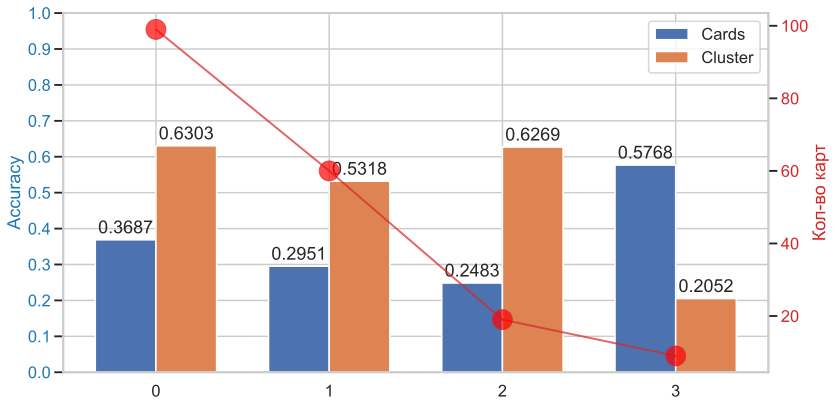

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['0', '1', '2', '3']
kards = [0.3687, 0.2951, 0.2483, 0.5768]
cluster = [0.6303, 0.5318, 0.6269, 0.2052]

num_of_transactions = np.array([[0, 99],[1,60],[2,19],[3,9]])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots(figsize=(12,6))
rects1 = ax1.bar(x - width/2, kards, width, label='Сards')
rects2 = ax1.bar(x + width/2, cluster, width, label='Cluster')

# Add some text for labels, title and custom x-axis tick labels, etc.
color = 'tab:blue'
ax1.set_ylabel('Accuracy', color=color)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim((0.0,1.0))
ax1.locator_params(nbins=10, axis='y')
ax1.legend()

ax1.bar_label(rects1, padding=3)
ax1.bar_label(rects2, padding=3)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Кол-во карт', color=color)  # we already handled the x-label with ax1
ax2.plot(num_of_transactions[:,0], num_of_transactions[:,1], '-o', color=color, ms=20, lw=2, alpha=0.7, mfc='red')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(b=False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


#fig.set_figwidth(12)    #  ширина Figure
#fig.set_figheight(6)    #  высота Figure

if not os.path.isfile(f'{PNG_PATH}/final_result_regression.png'):
  plt.savefig(f'{PNG_PATH}/final_result_regression', dpi=300)  
plt.show()

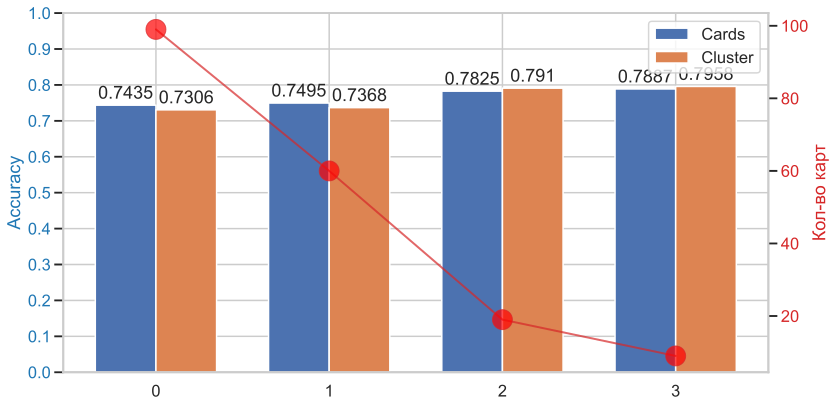

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['0', '1', '2', '3']
kards = [0.7435, 0.7495, 0.7825, 0.7887]
cluster = [0.7306, 0.7368, 0.7910, 0.7958]

num_of_transactions = np.array([[0, 99],[1,60],[2,19],[3,9]])

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax1 = plt.subplots(figsize=(12,6))
rects1 = ax1.bar(x - width/2, kards, width, label='Сards')
rects2 = ax1.bar(x + width/2, cluster, width, label='Cluster')

# Add some text for labels, title and custom x-axis tick labels, etc.
color = 'tab:blue'
ax1.set_ylabel('Accuracy', color=color)
ax1.set_xticks(x)
ax1.set_xticklabels(labels)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim((0.0,1.0))
ax1.locator_params(nbins=10, axis='y')
ax1.legend()

ax1.bar_label(rects1, padding=3)
ax1.bar_label(rects2, padding=3)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Кол-во карт', color=color)  # we already handled the x-label with ax1
ax2.plot(num_of_transactions[:,0], num_of_transactions[:,1], '-o', color=color, ms=20, lw=2, alpha=0.7, mfc='red')
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid(b=False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped


#fig.set_figwidth(12)    #  ширина Figure
#fig.set_figheight(6)    #  высота Figure

if not os.path.isfile(f'{PNG_PATH}/final_result_classification.png'):
  plt.savefig(f'{PNG_PATH}/final_result_classification', dpi=300)  
plt.show()